In [2]:
from os import chdir
chdir('..')

<IPython.core.display.Javascript object>


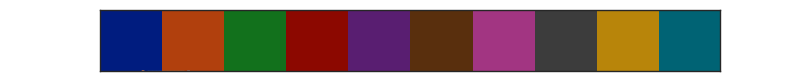

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import math
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale
from os import path
from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly, load_polygon, get_max_bounds_polys
%matplotlib notebook
sns.set(font_scale=2)  # crazy big
sns.set_style("white")
current_palette = sns.color_palette('dark')
sns.palplot(current_palette)


In [17]:
num_points = 2000
FIXTURES = "test_fixtures"
GEN_POLYS_FILE = path.join(FIXTURES,"generated", "polygons.pkl")

gen_polys, poly_params = pickle.load(open(GEN_POLYS_FILE, 'rb'))
df = pd.DataFrame.from_records(poly_params)
df.head()

,convexity,nv,pi,pr,ps,r
0,0.815492,100,0.1,100,0.1,0
1,0.799573,100,0.1,100,0.1,1
2,0.814719,100,0.1,100,0.1,2
3,0.817231,100,0.1,100,0.1,3
4,0.762802,100,0.1,100,0.1,4


<IPython.core.display.Javascript object>


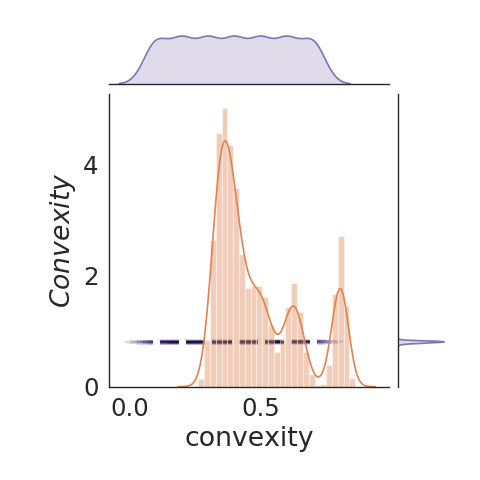

In [25]:
df_pi = df[df.ps == 0.1]
g = sns.jointplot(x="pi", y="convexity", data=df_pi, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Irregularity$", "$Convexity$");

<IPython.core.display.Javascript object>


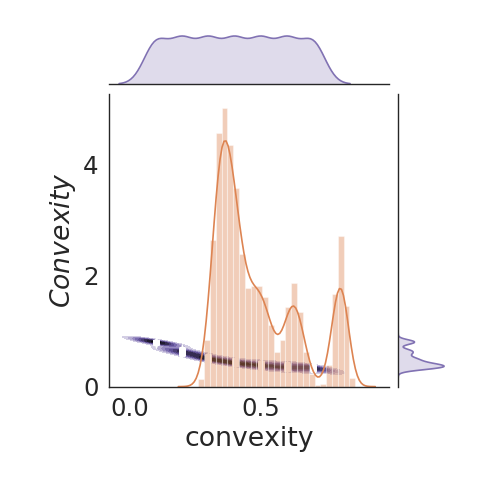

In [26]:
df_ps = df[df.pi == 0.1]
g = sns.jointplot(x="ps", y="convexity", data=df_ps, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Spikiness$", "$Convexity$");

In [32]:
sns.distplot(df['convexity'])